# Import Library 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from Swarm import DFO

# Checking Data

In [37]:
# Path ke direktori data
happy_dir = 'data/happy'
sad_dir = 'data/sad'

In [38]:
# Fungsi untuk load images
def load_images_from_folder(folder):
    images = []
    count = 0
    try:
        for filename in os.listdir(folder):
            count += 1
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    except:
        print(f'error pada iterasi ke-{count}')
    return images

In [39]:
happy_images = load_images_from_folder(happy_dir)
sad_images = load_images_from_folder(sad_dir)

In [40]:
happy_images[0].shape

(48, 48)

In [41]:
# Mengecek size setiap gambar happy apakah sama (48,48)
counter = 0
for image in happy_images:
  if str(image.shape) == '(48, 48)':
    counter += 1

if counter == len(happy_images):
  print('TRUE')
else:
  ('FALSE')

TRUE


In [42]:
# Mengecek size setiap gambar sad apakah sama (48,48)
counter = 0
for image in sad_images:
  if str(image.shape) == '(48, 48)':
    counter += 1

if counter == len(sad_images):
  print('TRUE')
else:
  ('FALSE')

TRUE


# Function for Preprocessing Data

In [43]:
def resize_images(images, img_size):
    """
    Fungsi untuk mengubah ukuran gambar.

    Args:
        images (list): List gambar yang akan diubah ukurannya.
        img_size (tuple): Ukuran gambar yang diinginkan (width, height).

    Returns:
        list: List gambar yang telah diubah ukurannya.
    """
    resized_images = []
    for img in images:
      resized_img = cv2.resize(img, img_size)
      resized_images.append(resized_img)
    return resized_images

In [44]:
# --- Fungsi Normalisasi Images ---
def normalize_images(images):
    """
    Melakukan normalisasi pada gambar grayscale.

    Args:
      images (list): List gambar yang akan dinormalisasi.

    Returns:
      list: List gambar yang telah dinormalisasi.
    """
    normalized_images = np.array(images) / 255.0
    return normalized_images

In [45]:
def augment_images(images):
    """
    Fungsi untuk melakukan augmentasi data pada gambar.

    Args:
        images (list): List gambar yang akan diaugmentasi.

    Returns:
        list: List gambar yang telah diaugmentasi.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    all_images = []  # List untuk menyimpan semua gambar (asli + augmentasi)
    for img in images:
        img = np.expand_dims(img, axis=-1)  # Tambahkan dimensi channel
        img = img.reshape((1,) + img.shape)  # Tambahkan dimensi batch

        all_images.append(img[0])  # Tambahkan gambar asli ke list

        # Generate gambar augmentasi dan tambahkan ke list
        for batch in datagen.flow(img, batch_size=1):
            all_images.append(batch[0])
            break  # Hanya ambil satu gambar augmentasi per gambar asli

    return all_images

In [46]:
# --- Fungsi Preprocessing ---
def preprocessing(happy_dir, sad_dir, img_size=(32, 32)):
    """
    Melakukan preprocessing pada data gambar.

    Args:
      happy_dir (str): Path ke direktori gambar "happy".
      sad_dir (str): Path ke direktori gambar "sad".
      img_size (tuple): Ukuran gambar yang diinginkan setelah resize (default: (32, 32)).
      augment (bool): Apakah akan melakukan augmentasi data (default: False).

    Returns:
      tuple: Tuple yang berisi data gambar dan label yang sudah di-preprocess.
    """
    happy_images = load_images_from_folder(happy_dir)
    sad_images = load_images_from_folder(sad_dir)

    happy_images = resize_images(happy_images, img_size)
    sad_images = resize_images(sad_images, img_size)

    happy_images = normalize_images(happy_images)
    sad_images = normalize_images(sad_images)

    happy_images = augment_images(happy_images)
    sad_images = augment_images(sad_images)

    # Gabungkan data dan buat label
    X = np.concatenate((happy_images, sad_images), axis=0) 
    y = np.concatenate((np.zeros(len(happy_images)), np.ones(len(sad_images))), axis=0)  # 0 = happy, 1 = sad
    y = y.astype(int)

    return X, y

In [47]:
X, y = preprocessing(happy_dir, sad_dir)

In [48]:
len(X)

5996

In [49]:
count_1 = 0
count_0 = 0
for i in y:
    if i == 0:
        count_0 += 1
    else:
        count_1 += 1

print(count_1)
print(count_0)
print(count_0 + count_1)

2924
3072
5996


In [50]:
# Bagi data menjadi training, validation set, dan testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [51]:
# Definisikan model LeNet-5
model = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 1)), # Sesuaikan dengan ukuran gambar
        layers.Conv2D(6, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation="relu"),
        layers.Dense(84, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [52]:
# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) 

In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,941 (238.05 KB)

 Trainable params: 60,941 (238.05 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# --- Fungsi Decode Fly Position ---
def decode_fly_position(fly):
  """
  Dekode posisi lalat (array 1D) menjadi bobot CNN (list of NumPy arrays).

  Args:
    fly (list): Posisi lalat dalam DFO.

  Returns:
    list: Bobot CNN.
  """

  weights = []
  start_index = 0

  for w in model.get_weights():
    # Hitung jumlah elemen dalam bobot
    w_size = np.prod(w.shape)

    # Ambil elemen dari posisi lalat sesuai dengan ukuran bobot
    w_values = fly[start_index : start_index + w_size]

    # Ubah bentuk elemen menjadi shape yang sesuai dengan bobot
    w_decoded = np.array(w_values).reshape(w.shape)

    # Tambahkan bobot yang telah didekode ke list
    weights.append(w_decoded)

    # Update start_index untuk bobot selanjutnya
    start_index += w_size

  return weights

In [76]:
# --- Fungsi Objektif untuk DFO ---
def objective_function(fly):
  """
  Fungsi objektif untuk DFO.

  Args:
    fly (list): Posisi lalat (representasi bobot CNN).

  Returns:
    float: Nilai fitness (akurasi atau loss).
  """

  # 1. Dekode posisi lalat menjadi bobot CNN
  weights = decode_fly_position(fly) 

  # 2. Tetapkan bobot ke model CNN
  model.set_weights(weights) 

  # 3. Latih model (sebagian epoch saja)
  history = model.fit(X_train, y_train, epochs=25, batch_size=32, 
                      validation_data=(X_val, y_val), verbose=0)

  # 4. Hitung nilai fitness
  #   Gunakan validasi loss
  fitness = min(history.history['val_loss'])

  return fitness

In [77]:
import random

class DFO():
    def __init__(self, f, bounds, NP, max_evals, dt):
        self.f = f
        self.bounds = bounds
        self.NP = NP
        self.max_evals = max_evals
        self.dt = dt
        self.best_fitness_history = [] # Menyimpan sejarah nilai fungsi terbaik
        """
        Args:
            f: Fungsi objektif yang akan diminimalkan.
            bounds: Batas atas dan bawah untuk setiap dimensi.
            NP: Jumlah lalat dalam populasi.
            max_evals: Jumlah maksimum evaluasi fungsi.
            dt: Parameter ambang batas.
        """
    def calculate_dfo(self):
        # Inisialisasi populasi lalat secara acak
        flies = [[random.uniform(self.bounds[d][0], self.bounds[d][1]) for d in range(len(self.bounds))] for _ in range(self.NP)]
        fitness = [self.f(fly) for fly in flies]  # Hitung fitness awal
        evals = self.NP  # Karena sayasudah menghitung fitness untuk NP lalat
        print(f"Evaluasi: {evals},  Fitness Terbaik: {min(fitness)}")

        while evals < self.max_evals:
            # Menemukan lalat terbaik (sb)
            sb_index = fitness.index(min(fitness))  # Indeks lalat terbaik
            sb = flies[sb_index]  # Lalat terbaik

            # Menemukan tetangga terbaik (nb) untuk setiap lalat
            nb = []
            for i in range(self.NP):
                left = flies[i-1] if i > 0 else flies[-1]  # Tetangga kiri
                right = flies[i+1] if i < self.NP-1 else flies[0]  # Tetangga kanan
                nb.append(min([left, right], key=lambda fly: fitness[flies.index(fly)]))  # Menggunakan fitness untuk menentukan tetangga terbaik

            # Memperbaharui posisi lalat
            for i in range(self.NP):
                for d in range(len(self.bounds)):
                    tau = nb[i][d] + random.uniform(0, 1) * (sb[d] - flies[i][d])
                    if random.random() < self.dt:
                        tau = self.bounds[d][0] + random.random() * (self.bounds[d][1] - self.bounds[d][0])
                    flies[i][d] = tau

                # Menghitung fitness untuk lalat yang diperbaharui
                fitness[i] = self.f(flies[i])  # Update fitness untuk lalat yang diperbaharui
                evals += 1
            # Simpan fitness terbaik di setiap iterasi
            best_fitness = min(fitness)
            self.best_fitness_history.append(best_fitness) # simpan best fitness
            print(f"Evaluasi: {evals},  Fitness Terbaik: {min(fitness)}")

        # Mengembalikan lalat terbaik setelah semua evaluasi selesai
        best_index = fitness.index(min(fitness))
        return flies[best_index], fitness[best_index], self.best_fitness_history  # Kembalikan posisi, fitness terbaik, dan fitness history terbaik

<h2>Mencoba beberapa kemungkinan<h2>

In [78]:
# Batas bobot 
bounds = [(-0.5, 0.5)] * sum([np.prod(w.shape) for w in model.get_weights()]) 

NP_values = [50]
max_evals = 500 # Jumlah evaluasi maksimum
dt_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # 0.2 - 0.8
# dt_values = [0.2,0.4,0.6,0.8] # 0.2 - 0.8

# Find Best Weights from DFO using Val_loss as fitness

In [79]:
# Buat objek DFO
results = {}  # Dictionary untuk menyimpan hasil

for NP in NP_values:
  for dt in dt_values:
    print(f"Menjalankan DFO dengan NP={NP}, dt={dt}")

    # Buat objek DFO
    dfo_optimizer = DFO(objective_function, bounds, NP, max_evals, dt)

    # Jalankan DFO
    best_fly, best_fitness, best_fitness_history = dfo_optimizer.calculate_dfo()

    # Simpan hasil
    results[(NP, dt)] = {
        'best_weights': decode_fly_position(best_fly),
        'best_fitness': best_fitness,
        'best_fitness_history': best_fitness_history,
    }

Menjalankan DFO dengan NP=50, dt=0.1
Evaluasi: 50,  Fitness Terbaik: 0.6087262630462646
Evaluasi: 100,  Fitness Terbaik: 0.6243951320648193
Evaluasi: 150,  Fitness Terbaik: 0.6469532251358032
Evaluasi: 200,  Fitness Terbaik: 0.6504052877426147
Evaluasi: 250,  Fitness Terbaik: 0.6754959225654602
Evaluasi: 300,  Fitness Terbaik: 0.6780385375022888
Evaluasi: 350,  Fitness Terbaik: 0.7090005874633789
Evaluasi: 400,  Fitness Terbaik: 0.7123686671257019
Evaluasi: 450,  Fitness Terbaik: 0.7115469574928284
Evaluasi: 500,  Fitness Terbaik: 0.7011554837226868
Menjalankan DFO dengan NP=50, dt=0.2
Evaluasi: 50,  Fitness Terbaik: 0.6117266416549683
Evaluasi: 100,  Fitness Terbaik: 0.6204708814620972
Evaluasi: 150,  Fitness Terbaik: 0.6374949216842651
Evaluasi: 200,  Fitness Terbaik: 0.6463642716407776
Evaluasi: 250,  Fitness Terbaik: 0.6342374682426453
Evaluasi: 300,  Fitness Terbaik: 0.6620364785194397
Evaluasi: 350,  Fitness Terbaik: 0.665442168712616
Evaluasi: 400,  Fitness Terbaik: 0.6708939671

Hasil untuk NP=50, dt=0.1:
  Best Fitness: 0.7011554837226868
Hasil untuk NP=50, dt=0.2:
  Best Fitness: 0.6933987736701965
Hasil untuk NP=50, dt=0.3:
  Best Fitness: 0.6610687971115112
Hasil untuk NP=50, dt=0.4:
  Best Fitness: 0.6621645092964172
Hasil untuk NP=50, dt=0.5:
  Best Fitness: 0.6362753510475159
Hasil untuk NP=50, dt=0.6:
  Best Fitness: 0.6256941556930542
Hasil untuk NP=50, dt=0.7:
  Best Fitness: 0.6337079405784607
Hasil untuk NP=50, dt=0.8:
  Best Fitness: 0.60238116979599
Hasil untuk NP=50, dt=0.9:
  Best Fitness: 0.622742772102356


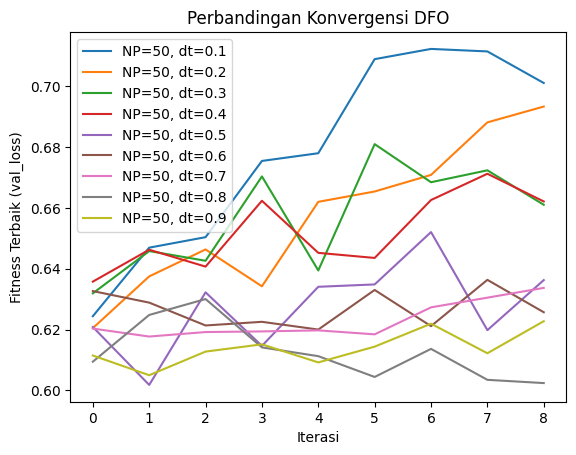

In [80]:
# Bandingkan performa
for (NP, dt), result in results.items():
  print(f"Hasil untuk NP={NP}, dt={dt}:")
  print(f"  Best Fitness: {result['best_fitness']}")

  plt.plot(result['best_fitness_history'], label=f'NP={NP}, dt={dt}')

plt.xlabel('Iterasi')
plt.ylabel('Fitness Terbaik (val_loss)')
plt.title('Perbandingan Konvergensi DFO')
plt.legend()
plt.show()

~~~~~~~~~~Hasil untuk NP=50, dt=0.1:~~~~~~~~~~
  Best Fitness: 0.7011554837226868
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4819 - loss: 1.1314
Test Loss: 1.055429458618164
Test Accuracy: 0.4877777695655823
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.48777777777777775
Precision: 0.48625
Recall: 0.8861047835990888
F1-Score: 0.6279257465698144
Confusion Matrix:
 [[ 50 411]
 [ 50 389]]


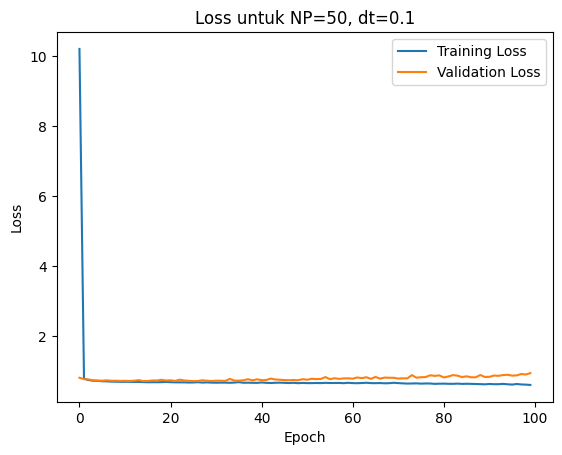

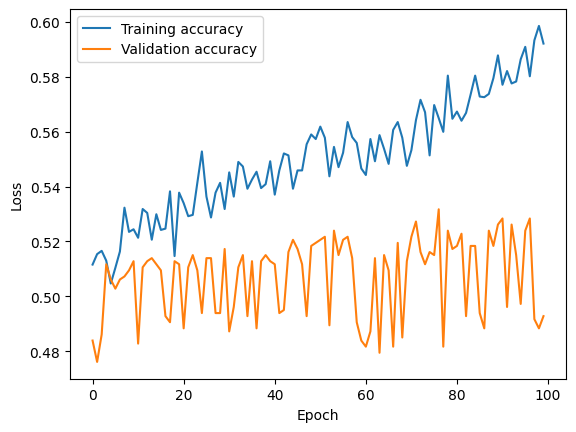

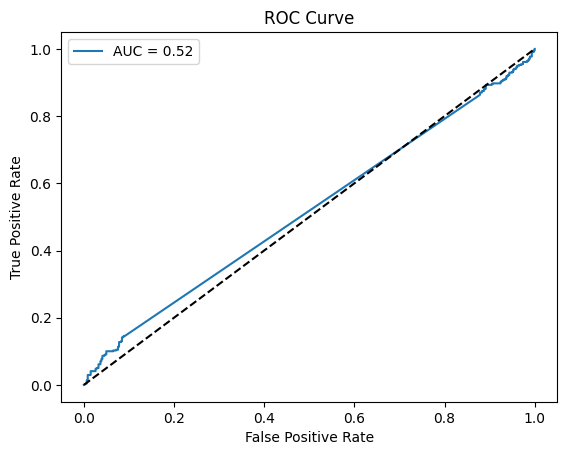

~~~~~~~~~~Hasil untuk NP=50, dt=0.2:~~~~~~~~~~
  Best Fitness: 0.6933987736701965
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6509 - loss: 2.1399
Test Loss: 2.0905590057373047
Test Accuracy: 0.6322222352027893
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.6322222222222222
Precision: 0.6139240506329114
Recall: 0.662870159453303
F1-Score: 0.6374589266155531
Confusion Matrix:
 [[278 183]
 [148 291]]


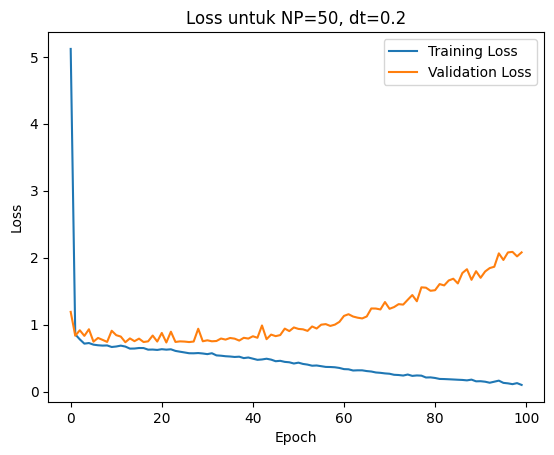

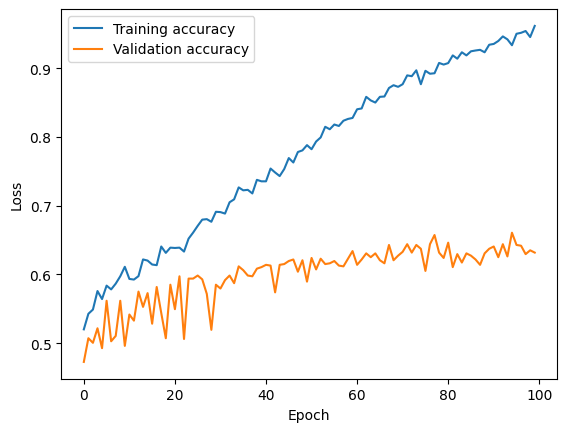

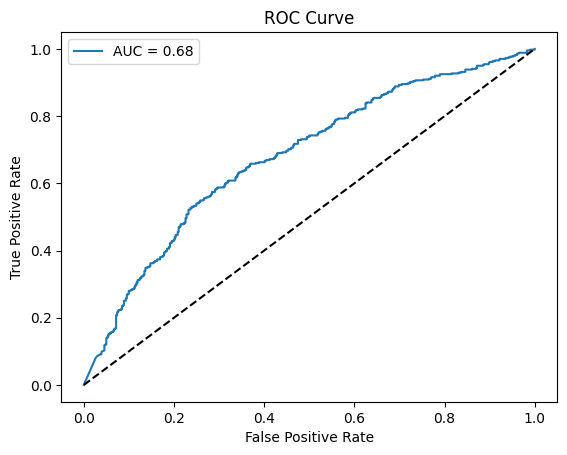

~~~~~~~~~~Hasil untuk NP=50, dt=0.3:~~~~~~~~~~
  Best Fitness: 0.6610687971115112
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6433 - loss: 3.7439
Test Loss: 3.6755354404449463
Test Accuracy: 0.652222216129303
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.6522222222222223
Precision: 0.6451612903225806
Recall: 0.6378132118451025
F1-Score: 0.6414662084765178
Confusion Matrix:
 [[307 154]
 [159 280]]


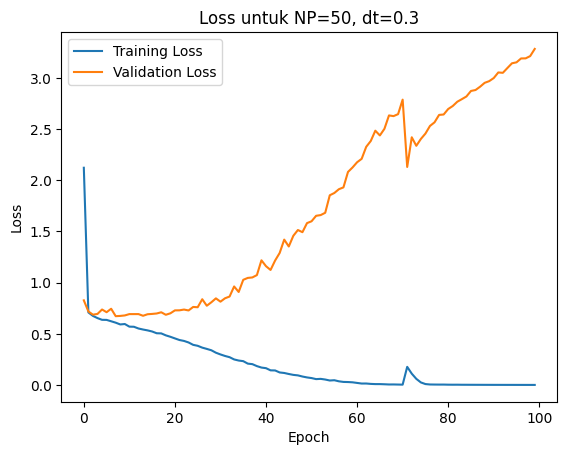

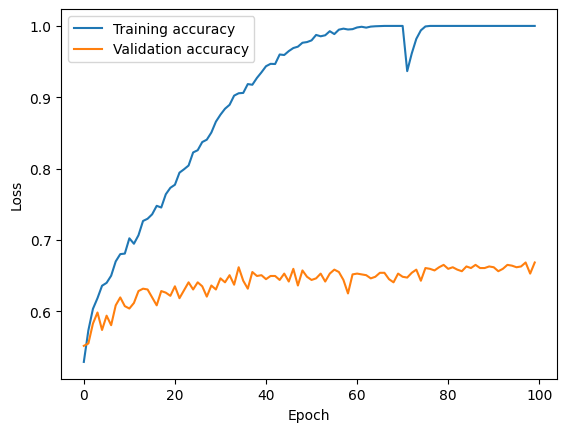

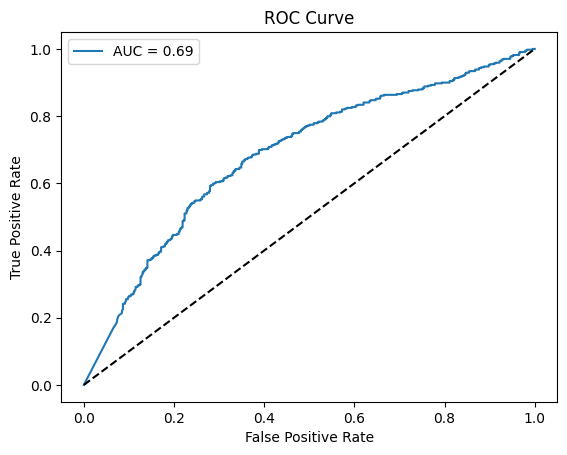

~~~~~~~~~~Hasil untuk NP=50, dt=0.4:~~~~~~~~~~
  Best Fitness: 0.6621645092964172
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6164 - loss: 5.2395
Test Loss: 4.637609958648682
Test Accuracy: 0.653333306312561
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.6533333333333333
Precision: 0.6420581655480985
Recall: 0.6537585421412301
F1-Score: 0.6478555304740407
Confusion Matrix:
 [[301 160]
 [152 287]]


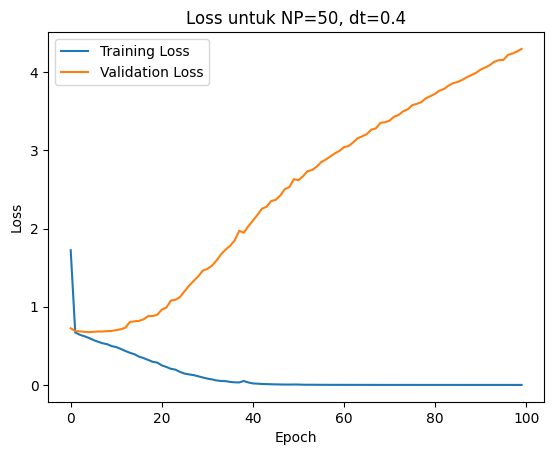

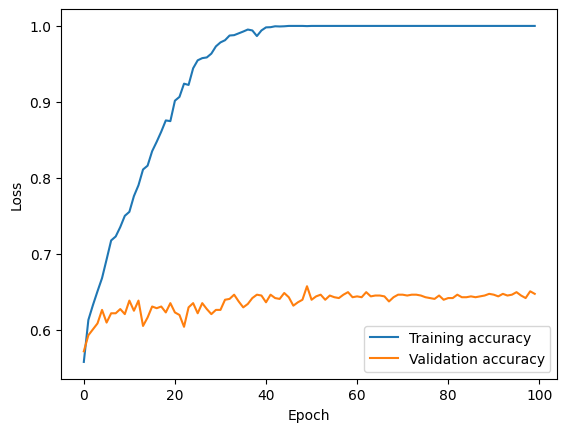

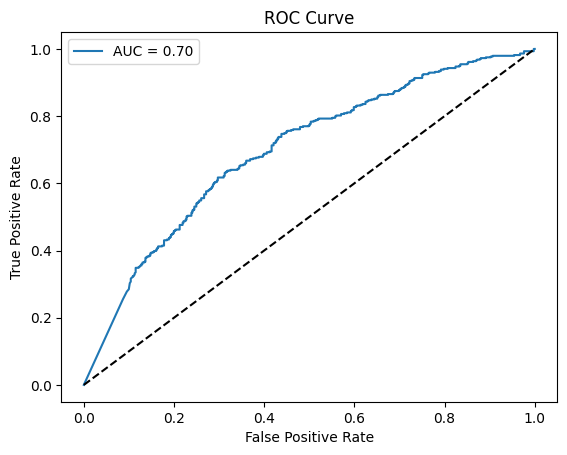

~~~~~~~~~~Hasil untuk NP=50, dt=0.5:~~~~~~~~~~
  Best Fitness: 0.6362753510475159
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6720 - loss: 4.7320
Test Loss: 4.3316521644592285
Test Accuracy: 0.6577777862548828
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.6577777777777778
Precision: 0.6445916114790287
Recall: 0.6651480637813212
F1-Score: 0.6547085201793722
Confusion Matrix:
 [[300 161]
 [147 292]]


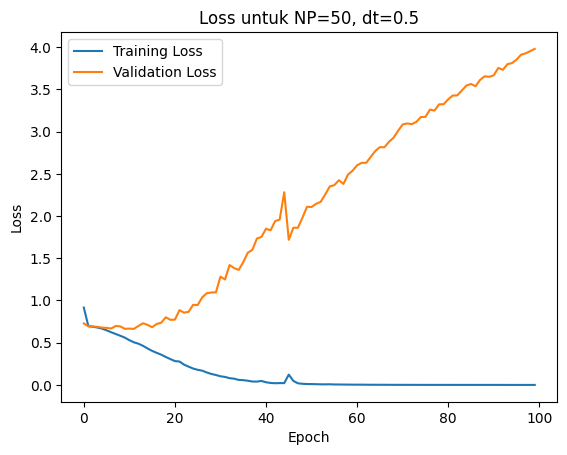

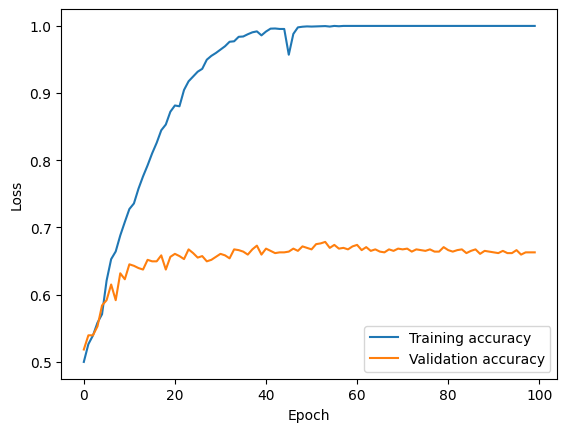

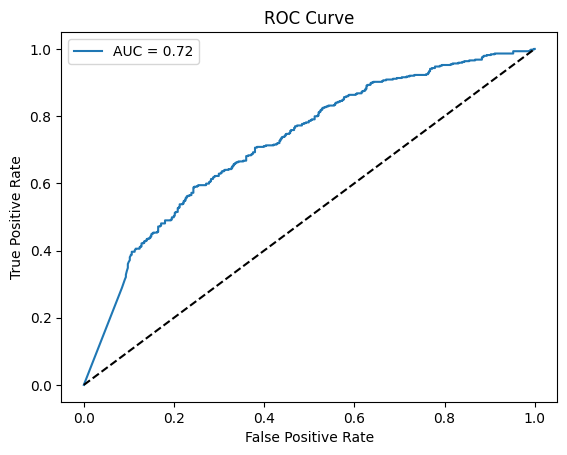

~~~~~~~~~~Hasil untuk NP=50, dt=0.6:~~~~~~~~~~
  Best Fitness: 0.6256941556930542
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6395 - loss: 4.0208
Test Loss: 3.7846922874450684
Test Accuracy: 0.6544444561004639
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.6544444444444445
Precision: 0.65311004784689
Recall: 0.621867881548975
F1-Score: 0.6371061843640606
Confusion Matrix:
 [[316 145]
 [166 273]]


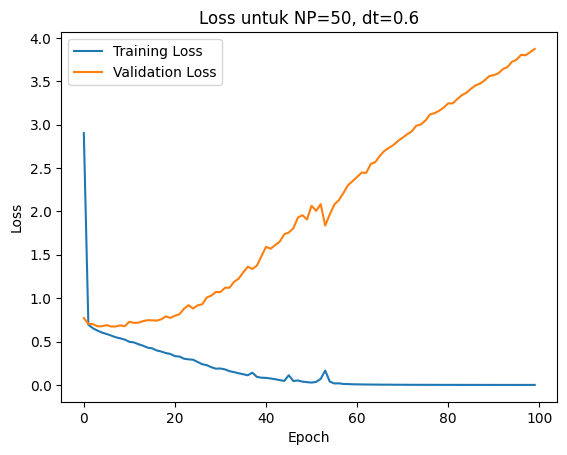

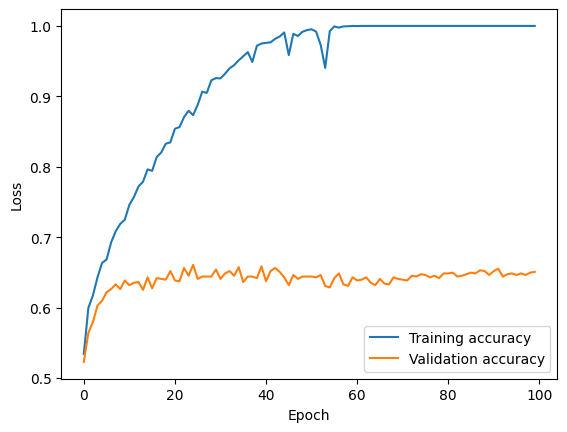

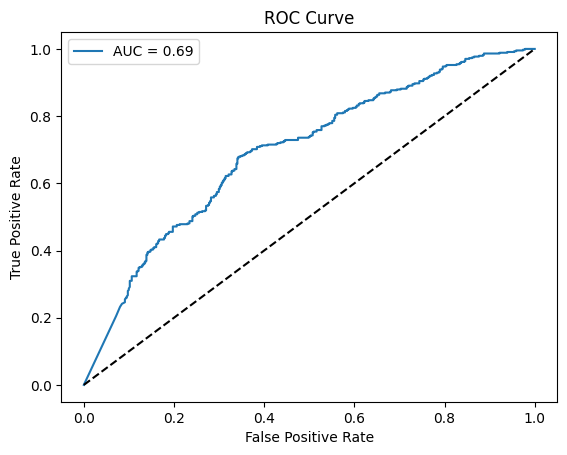

~~~~~~~~~~Hasil untuk NP=50, dt=0.7:~~~~~~~~~~
  Best Fitness: 0.6337079405784607
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6529 - loss: 3.7861
Test Loss: 3.8010475635528564
Test Accuracy: 0.648888885974884
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.6488888888888888
Precision: 0.6357615894039735
Recall: 0.6560364464692483
F1-Score: 0.6457399103139013
Confusion Matrix:
 [[296 165]
 [151 288]]


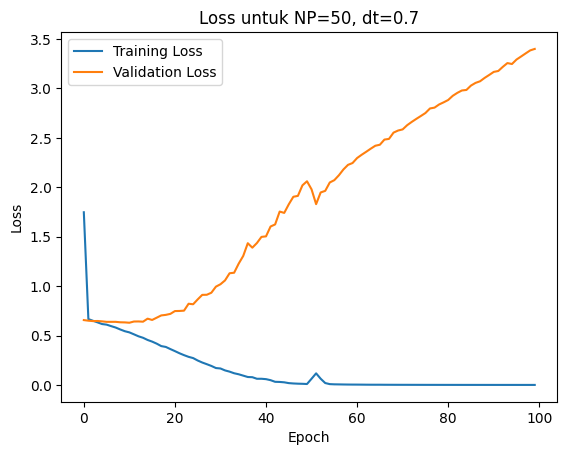

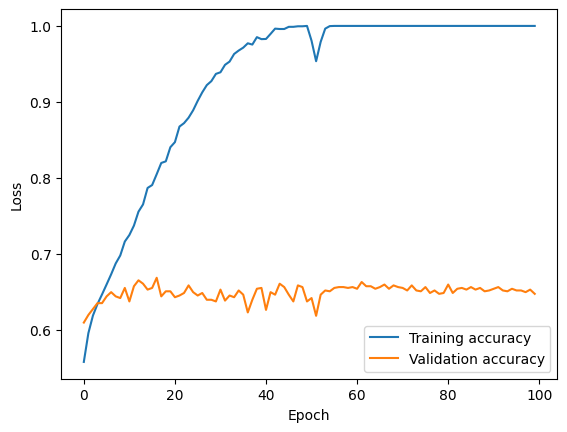

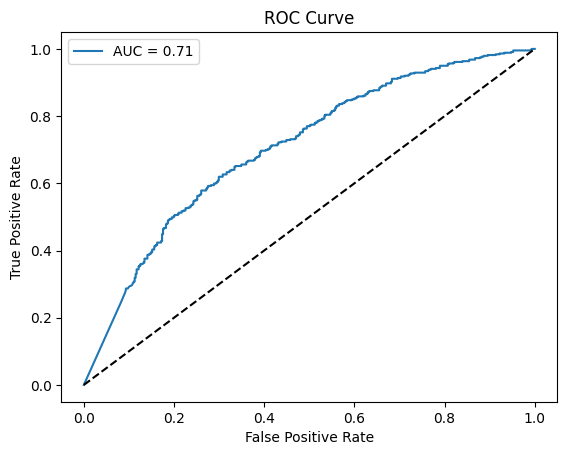

~~~~~~~~~~Hasil untuk NP=50, dt=0.8:~~~~~~~~~~
  Best Fitness: 0.60238116979599
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6434 - loss: 5.1987
Test Loss: 4.177000522613525
Test Accuracy: 0.6722221970558167
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.6722222222222223
Precision: 0.6607142857142857
Recall: 0.6742596810933941
F1-Score: 0.6674182638105975
Confusion Matrix:
 [[309 152]
 [143 296]]


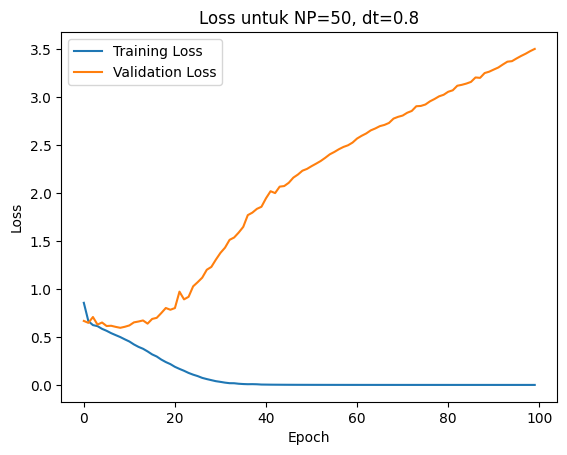

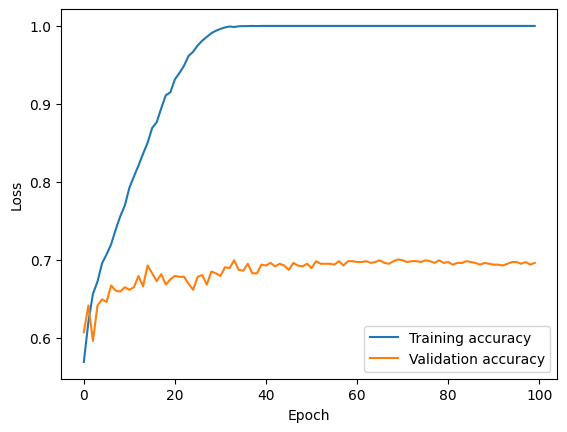

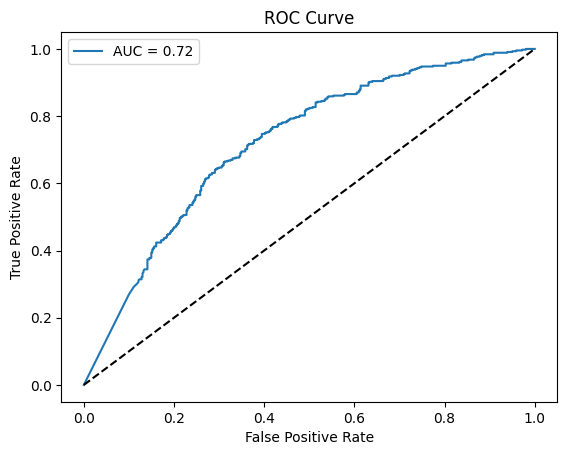

~~~~~~~~~~Hasil untuk NP=50, dt=0.9:~~~~~~~~~~
  Best Fitness: 0.622742772102356
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6510 - loss: 4.6245
Test Loss: 4.389207363128662
Test Accuracy: 0.6611111164093018
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.6611111111111111
Precision: 0.6550925925925926
Recall: 0.6446469248291572
F1-Score: 0.6498277841561424
Confusion Matrix:
 [[312 149]
 [156 283]]


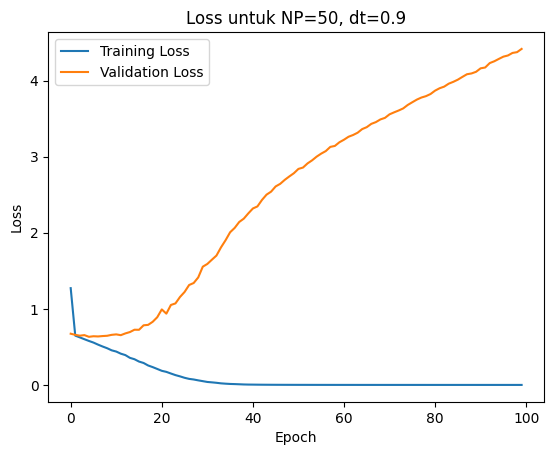

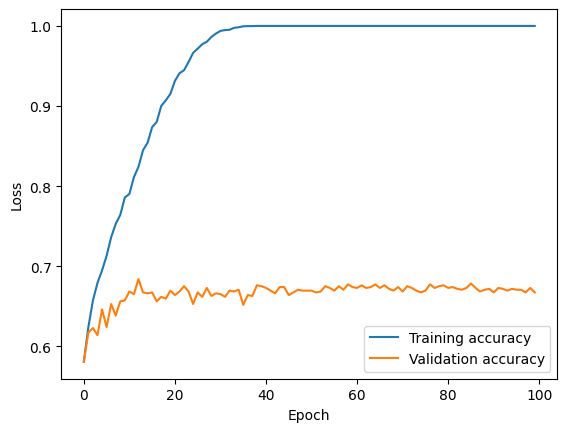

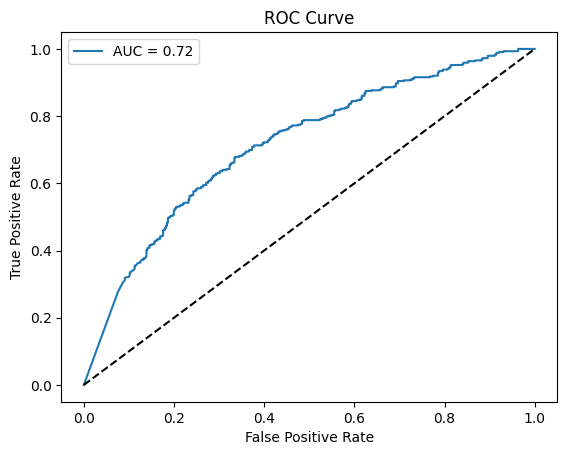

In [ ]:
# --- Evaluasi dan Visualisasi ---
accuracy_results = {}

for (NP, dt), result in results.items():
    print(f"{'~'*10}Hasil untuk NP={NP}, dt={dt}:{'~'*10}")
    print(f"  Best Fitness: {result['best_fitness']}")

    # Tetapkan best_weight ke model
    model.set_weights(result['best_weights'])

    # Latih model dengan best_weight
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                        validation_data=(X_val, y_val), verbose=0)

    # Evaluasi performa model pada data testing
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas (0 atau 1)

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    confusion_mat = confusion_matrix(y_test, y_pred_classes)

    accuracy_results[dt] = accuracy

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:\n", confusion_mat)

    # Visualisasi loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss untuk NP={NP}, dt={dt}')
    plt.legend()
    plt.show()

    # Visualisasi Akurasi
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Visualiasi ROC-AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    

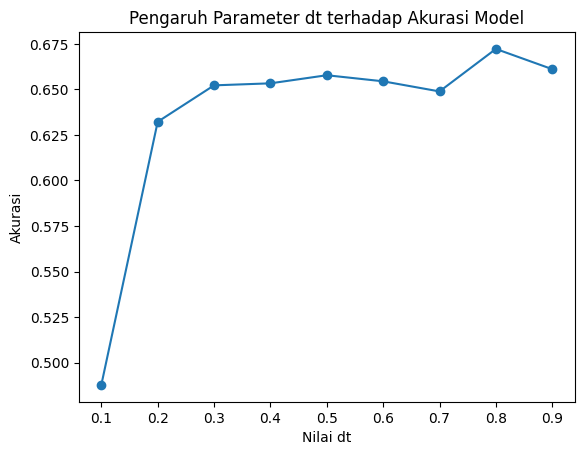

In [98]:
plt.plot(dt_values, [accuracy_results[dt] for dt in dt_values], marker='o')
plt.xlabel("Nilai dt")
plt.ylabel("Akurasi")
plt.title("Pengaruh Parameter dt terhadap Akurasi Model")
plt.show()